# Packages

In [803]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory= False)

togeth = pd.concat([traindf,testdf])

traindf.dropna(inplace = True)
testdf.dropna(inplace = True)

In [804]:
nas = list(testdf.isna().sum(axis = 1))
indexes = list(testdf.index)
keepinds = []
dropinds = []
for i in range(len(indexes)):
    if nas[i] == 0:
        keepinds.append(i)
    else:
        dropinds.append(i)
droptest = testdf.loc[dropinds].copy()
testdf = testdf.loc[keepinds].copy()

In [775]:
cryotrain = traindf[traindf.CryoSleep == True].copy()
cryotest = testdf[testdf.CryoSleep == True].copy()

Careful to clean indexes to start with so that filling nas doesnt accidentally double fill rows

# Splitting Columns

Split Group

In [806]:
def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df.Group = df.Group.astype('float')
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    df.GroupNumber = df.GroupNumber.astype('float')
    return df


Split Name

In [807]:
def split_names(df):
    # Create new columns for first name and last name
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else pd.NA)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) else pd.NA)
    return df


Split Cabin

In [808]:
def split_cabin(df):
    df['CabinDeck'] = df['Cabin'].apply(lambda x: x.split("/" )[0] if pd.notna(x) else pd.NA)
    custom_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
    df['CabinDeck'] = pd.Categorical(df['CabinDeck'], categories=custom_order, ordered=True)
    df['CabinSide'] = df['Cabin'].apply(lambda x: x.split("/")[2] if pd.notna(x) else pd.NA)
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split("/")[1]) if pd.notna(x) else pd.NA)
    return df


In [809]:
def splits(df):
    df = split_group_number(df)
    df = split_names(df)
    df = split_cabin(df)
    return df
traindf = splits(traindf)
testdf = splits(testdf)

# Feature Engineering

## Age

Agebin

In [810]:
togeth['Agebin'] = pd.qcut(togeth['Age'], 4)


under 13

In [811]:
def under_13(df):
    df['Under13'] = df['Age'].apply(lambda x: True if x < 13 else False if x >= 13 else pd.NA)
    return df


under 18

In [812]:
def under_18(df):
    df['Under18'] = df['Age'].apply(lambda x: True if x < 18 else False if x >= 18 else pd.NA)
    return df

under 19

In [813]:
def under_19(df):
    df['Under19'] = df['Age'].apply(lambda x: True if x < 19 else False if x >= 19 else pd.NA)
    return df

## Cabin

CabinSize

In [814]:
def cabin_size(df):
    def cabin_size_apply(row):
        if pd.isna(row.Cabin):
            if row.GroupSize == 1:
                return 1
            else:
                return pd.NA
        else:
            samecabin = df[df.Cabin == row.Cabin]
            return len(samecabin)
    df['CabinSize'] = df.apply(cabin_size_apply, axis = 1)
    return df

SoloCabin

In [815]:
def solo_cabin(df):
    def solo_cabin_apply(row):
        if pd.isna(row.Cabin):
            if row.GroupSize == 1:
                return True
            else:
                return pd.NA
        size = len(df[df.Cabin == row.Cabin])
        return size == 1
    df['SoloCabin'] = df.apply(solo_cabin_apply, axis = 1)
    return df


## Family

Family Size

In [816]:
def family_size(df):
    df['FamilySize'] = df.apply(lambda row: pd.NA if pd.isna(row['LastName']) else df[(df['LastName'] == row['LastName']) & (df['Group'] == row['Group'])].shape[0], axis=1)
    return df


## Group

Group Size

In [817]:
def group_size(df):
    def group_size_apply(row):
        group = df[df.Group == row.Group]
        return len(group)
    df['GroupSize'] = df.apply(group_size_apply, axis = 1)
    return df


## Spending

Total Ammenities

In [818]:
def total_ammenities(df):
    df['TotalAmmenities'] = df[['Spa','VRDeck','FoodCourt','ShoppingMall']].sum(axis = 1)
    return df

Total Cabin ammenities

In [819]:
def total_cabin_ammenities(df):
    def total_cabin_ammenities_apply(row):
        if pd.isna(row.Cabin):
            return pd.NA
        samecabin = df[df.Cabin == row.Cabin]
        return np.sum(samecabin.TotalAmmenities)
    df['TotalCabinAmmenities'] = df.apply(total_cabin_ammenities_apply, axis = 1)
    return df

Total Spending

In [820]:
spends = ['Spa','FoodCourt','VRDeck','ShoppingMall','RoomService']
def total_spending(df):
    def total_spending_apply(row):
        if pd.isna(row.RoomService):
            return pd.NA
        else:
            totalspending = 0
            for item in spends:
                if not pd.isna(row[item]):
                    totalspending += row[item]
            return totalspending
    df['TotalSpending'] = df.apply(total_spending_apply, axis = 1)
    return df

Total Cabin Spending

In [821]:
def total_cabin_spending(df):
    def total_cabin_spending_apply(row):
        if pd.isna(row.Cabin):
            return pd.NA
        samecabin = df[df.Cabin == row.Cabin]
        return np.sum(samecabin.TotalSpending)
    df['TotalCabinSpending'] = df.apply(total_cabin_spending_apply, axis = 1)
    return df

Total Cabin Room Service (careful of Cryo and underage)

In [822]:
def total_cabin_room_service(df):
    def total_cabin_room_service_apply(row):
        if pd.isna(row.Cabin):
            return pd.NA
        samecabin = df[df.Cabin == row.Cabin]
        return np.sum(samecabin.RoomService)
    df['TotalCabinRoomService'] = df.apply(total_cabin_room_service_apply, axis = 1)
    return df

Total Family Ammenities

In [823]:
def calculate_family_spending(df):
    # Define the columns related to spending
    spending_columns = ['VRDeck', 'Spa', 'RoomService', 'FoodCourt', 'ShoppingMall']

    # Group the DataFrame by last name and group, and calculate the total spending for each family
    family_spending = df.groupby(['LastName', 'Group'])[spending_columns].transform('sum')

    # Rename the family spending columns to distinguish them from the original columns
    family_spending.columns = [col + '_Family' for col in spending_columns]

    # Add the total family spending and total family amenities columns to the DataFrame
    df = pd.concat([df, family_spending], axis=1)

    famamenities = ['VRDeck_Family', 'Spa_Family', 'FoodCourt_Family', 'ShoppingMall_Family']
    famspending = ['VRDeck_Family', 'Spa_Family', 'RoomService_Family', 'FoodCourt_Family', 'ShoppingMall_Family']
    df['TotalFamilyAmmenities'] = df[famamenities].sum(axis=1)
    df['TotalFamilySpending'] = df[famspending].sum(axis=1)

    return df


Total Family Spending

In [824]:
def fe(df):
    df = under_18(df)
    df = under_19(df)
    df = under_13(df)
    df = group_size(df)
    df = cabin_size(df)
    df = solo_cabin(df)
    df = family_size(df)
    df = total_ammenities(df)
    df = total_cabin_ammenities(df)
    df = total_spending(df)
    df = total_cabin_spending(df)
    df = total_cabin_room_service(df)
    df = calculate_family_spending(df)
    return df
traindf = fe(traindf)
testdf = fe(testdf)

# Impute

## Spending

if cyrosleep then all spendings = 0

In [650]:
cryodict = {'RoomService':0,'FoodCourt' : 0, 'ShoppingMall' : 0, 'Spa' : 0, 'VRDeck' : 0}
def fillspending0(df):
    df.loc[df.CryoSleep == True, list(cryodict.keys())] = df.loc[df.CryoSleep == True, list(cryodict.keys())].fillna(value=cryodict)
    return df


if under 13 then spending = 0

In [651]:
spending = ['RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']
def spending_under_13(df):
    df.loc[df.Age < 13, spending] = df.loc[df.Age < 13, spending].fillna(0)
    return df

In [652]:
def spending_impute(df):
    df = fillspending0(df)
    df = spending_under_13(df)
    return df
togeth = spending_impute(togeth)

## CabinDeck

## CabinSide

Fills CabinSide if anyone with the same group in either data set

In [741]:
def fill_cabin_side_by_group(df):
    for index, row in df.iterrows():
        if pd.isna(row['CabinSide']):
            matching_rows = togeth[togeth['Group'] == row['Group']]
            non_nan_deck = matching_rows.dropna(subset=['CabinSide'])
            if not non_nan_deck.empty:
                side_to_fill = non_nan_deck['CabinSide'].values[0]
                df.at[index, 'CabinSide'] = side_to_fill
    return df


In [742]:
def cabinside_impute(df):
    df = fill_cabin_side_by_group(df)
    return df
togeth = cabinside_impute(togeth)

## CryoSleep

if any spending > 0 then cryosleep = false

In [743]:
def not_cryosleep_if_spending(df):
    for index, row in df[df['CryoSleep'].isna()].iterrows():
        if (row[spending] > 0).any():
            df.at[index, 'CryoSleep'] = False
    return df


Very unlikely to be in cryosleep if earth and F and prety unlikely with E also

In [744]:
def cryosleep_if_f_and_earth(df):
    df.loc[(df['HomePlanet'] == 'Earth') & (df['CabinDeck'] == 'F'), 'CryoSleep'] = False
    return df

If in F and spending == 0 and over 13 then highly likely cyrosleep (G pretty likely too)

If in D and from Mars then highly likely cyrosleep

In [745]:
def cryosleep_impute(df):
    df = not_cryosleep_if_spending(df)
    df = cryosleep_if_f_and_earth(df)
    return df
togeth = cryosleep_impute(togeth)

## Destination

In [746]:
def bunch_conds_dest(df):
    condition = (df.Age > 18) & (df.CryoSleep == False) & (df.TotalSpending < 400)
    spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    for col in spending_columns:
        condition &= ~df[col].isna()

    df.loc[condition, 'Destination'] = df.loc[condition, 'Destination'].fillna('TRAPPIST-1e')
    return df


In [747]:
def destination_impute(df):
    df = bunch_conds_dest(df)
    return df
togeth = destination_impute(togeth)

## Age

if VIP then not under 18

In [749]:
def not_under_18_if_vip(df):
    df['Under18'] = df.apply(lambda row: False if pd.isna(row['Age']) and row['VIP'] == True else row['Under18'], axis=1)
    return df

# Call the function to update the DataFrame


not under 13 if spending

In [750]:
def age_impute(df):
    df = not_under_18_if_vip(df)
    return df
togeth = age_impute(togeth)

## HomePlanet

Fill homeplanet by LastName

In [751]:
def fill_home_planet_by_last_name(df):
    for index, row in df.iterrows():
        if pd.isna(row['HomePlanet']):
            matching_rows = df[df['LastName'] == row['LastName']]
            non_nan_planet = matching_rows.dropna(subset=['HomePlanet'])
            if not non_nan_planet.empty:
                planet_to_fill = non_nan_planet['HomePlanet'].values[0]
                df.at[index, 'HomePlanet'] = planet_to_fill
    return df


Fill homeplanet by Group

In [752]:
def fill_home_planet_by_group(df):
    for index, row in df.iterrows():
        if pd.isna(row['HomePlanet']):
            matching_rows = df[df['Group'] == row['Group']]
            non_nan_planet = matching_rows.dropna(subset=['HomePlanet'])
            if not non_nan_planet.empty:
                planet_to_fill = non_nan_planet['HomePlanet'].values[0]
                df.at[index, 'HomePlanet'] = planet_to_fill
    return df


Fill Homeplanet by cabindeck A,B,C

In [753]:
def home_planet_from_cabindeck_abc(df):
    df.loc[df['CabinDeck'].isin(['A', 'B', 'C']), 'HomePlanet'] = df.loc[df['CabinDeck'].isin(['A', 'B', 'C']), 'HomePlanet'].fillna('Europa')
    return df


FillHomeplanet by cabindeck G

In [754]:
def home_planet_from_cabindeck_g(df):
    df.loc[df['CabinDeck']== 'G', 'HomePlanet'] = df.loc[df['CabinDeck'] == 'G', 'HomePlanet'].fillna('Earth')
    return df


In [755]:
def homeplanet_impute(df):
    df = fill_home_planet_by_group(df)
    df = fill_home_planet_by_last_name(df)
    df = home_planet_from_cabindeck_abc(df)
    df = home_planet_from_cabindeck_g(df)
    return df
togeth = homeplanet_impute(togeth)

## VIP

not vip if under 18

In [756]:
def not_vip_underage(df):
    df.loc[df.Age < 18,'VIP'] = df.loc[df.Age < 18, 'VIP'].fillna(False)
    return df

Not Vip if Earth

In [757]:
def not_vip_earth(df):
    df.loc[df.HomePlanet == 'Earth','VIP'] = df.loc[df.HomePlanet == 'Earth','VIP'].fillna(False)
    return df

not vip if mars and cryosleep

In [758]:
def not_vip_mars_cryo(df):
    df.loc[(df.HomePlanet == 'Mars') & (df.CryoSleep == True),'VIP'] = df.loc[(df.HomePlanet == 'Mars') & (df.CryoSleep == True),'VIP'].fillna(False)
    return df

Not VIP if G

In [759]:
def not_vip_g(df):
    df.loc[df.CabinDeck == 'G','VIP'] = df.loc[df.CabinDeck == 'G','VIP'].fillna(False)
    return df

In [760]:
def vip_impute(df):
    df = not_vip_underage(df)
    df = not_vip_earth(df)
    df = not_vip_mars_cryo(df)
    df = not_vip_g(df)
    return df
togeth = vip_impute(togeth)

## Spending

# final impute

# RandomForest

In [ ]:
def finalimpute(df):
    df = spending_impute(df)
    df = cabinside_impute(df)
    df = destination_impute(df)
    df = cryosleep_impute(df)
    df = age_impute(df)
    df = homeplanet_impute(df)
    df = spending_impute(df)
    return df


In [301]:
trainsubset = list(fi.cols[:23]).copy()
subset = list(fi.cols[:23]).copy()

In [302]:
trainsubset.append('PassengerId')
subset.append('PassengerId')
trainsubset.append('Transported')
trainsubset.remove('TotalCabinAmmenities')
subset.append('TotalCabinAmmenities')
trainsubset.remove('Cabin')
subset.append('TotalCabinAmmenities')
trainsubset.remove('TotalAmmenities')
subset.remove('TotalAmmenities')

In [304]:
traindfsubset = traindf[trainsubset].copy()
testdfsubset = testdf[subset].copy()

In [622]:
traindf.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Group', 'GroupNumber', 'FirstName', 'LastName',
       'CabinDeck', 'CabinSide', 'CabinNum', 'Under18', 'Under19', 'Under13',
       'GroupSize', 'CabinSize', 'SoloCabin', 'FamilySize', 'TotalAmmenities',
       'TotalCabinAmmenities', 'TotalSpending', 'TotalCabinSpending',
       'TotalCabinRoomService', 'VRDeck_Family', 'Spa_Family',
       'RoomService_Family', 'FoodCourt_Family', 'ShoppingMall_Family',
       'TotalFamilyAmmenities', 'TotalFamilySpending'],
      dtype='object')

In [750]:
trainsubset = traindf[subset]


In [833]:
trainsubset

,TotalSpending,TotalAmmenities,CryoSleep,Spa,VRDeck,FoodCourt,RoomService,ShoppingMall,HomePlanet,PassengerId,CabinNum,Age,Transported
7138,0.0,0.0,True,0.0,0.0,0.0,0.0,0.0,Europa,7609_02,83,39.0,True
8102,4686.0,4686.0,False,1841.0,1547.0,1298.0,0.0,0.0,Europa,8656_02,103,38.0,False
8101,10553.0,10553.0,False,1663.0,4435.0,4455.0,0.0,0.0,Europa,8656_01,103,29.0,False
3524,2129.0,1308.0,False,27.0,321.0,960.0,821.0,0.0,Europa,3781_01,44,38.0,False
5550,2447.0,2447.0,False,5.0,0.0,2427.0,0.0,15.0,Europa,5919_01,55,26.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,Earth,1714_01,265,5.0,False
5578,0.0,0.0,True,0.0,0.0,0.0,0.0,0.0,Earth,5944_01,969,32.0,True
5846,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,Earth,6189_01,1004,3.0,True
2254,7411.0,7411.0,False,3133.0,2447.0,1829.0,0.0,2.0,Europa,2414_01,1,42.0,False


In [834]:
a = list(trainsubset.columns)
a.remove('Transported')
a

['TotalSpending',
 'TotalAmmenities',
 'CryoSleep',
 'Spa',
 'VRDeck',
 'FoodCourt',
 'RoomService',
 'ShoppingMall',
 'HomePlanet',
 'PassengerId',
 'CabinNum',
 'Age']

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

decision tree prediction 0.7842543527630583


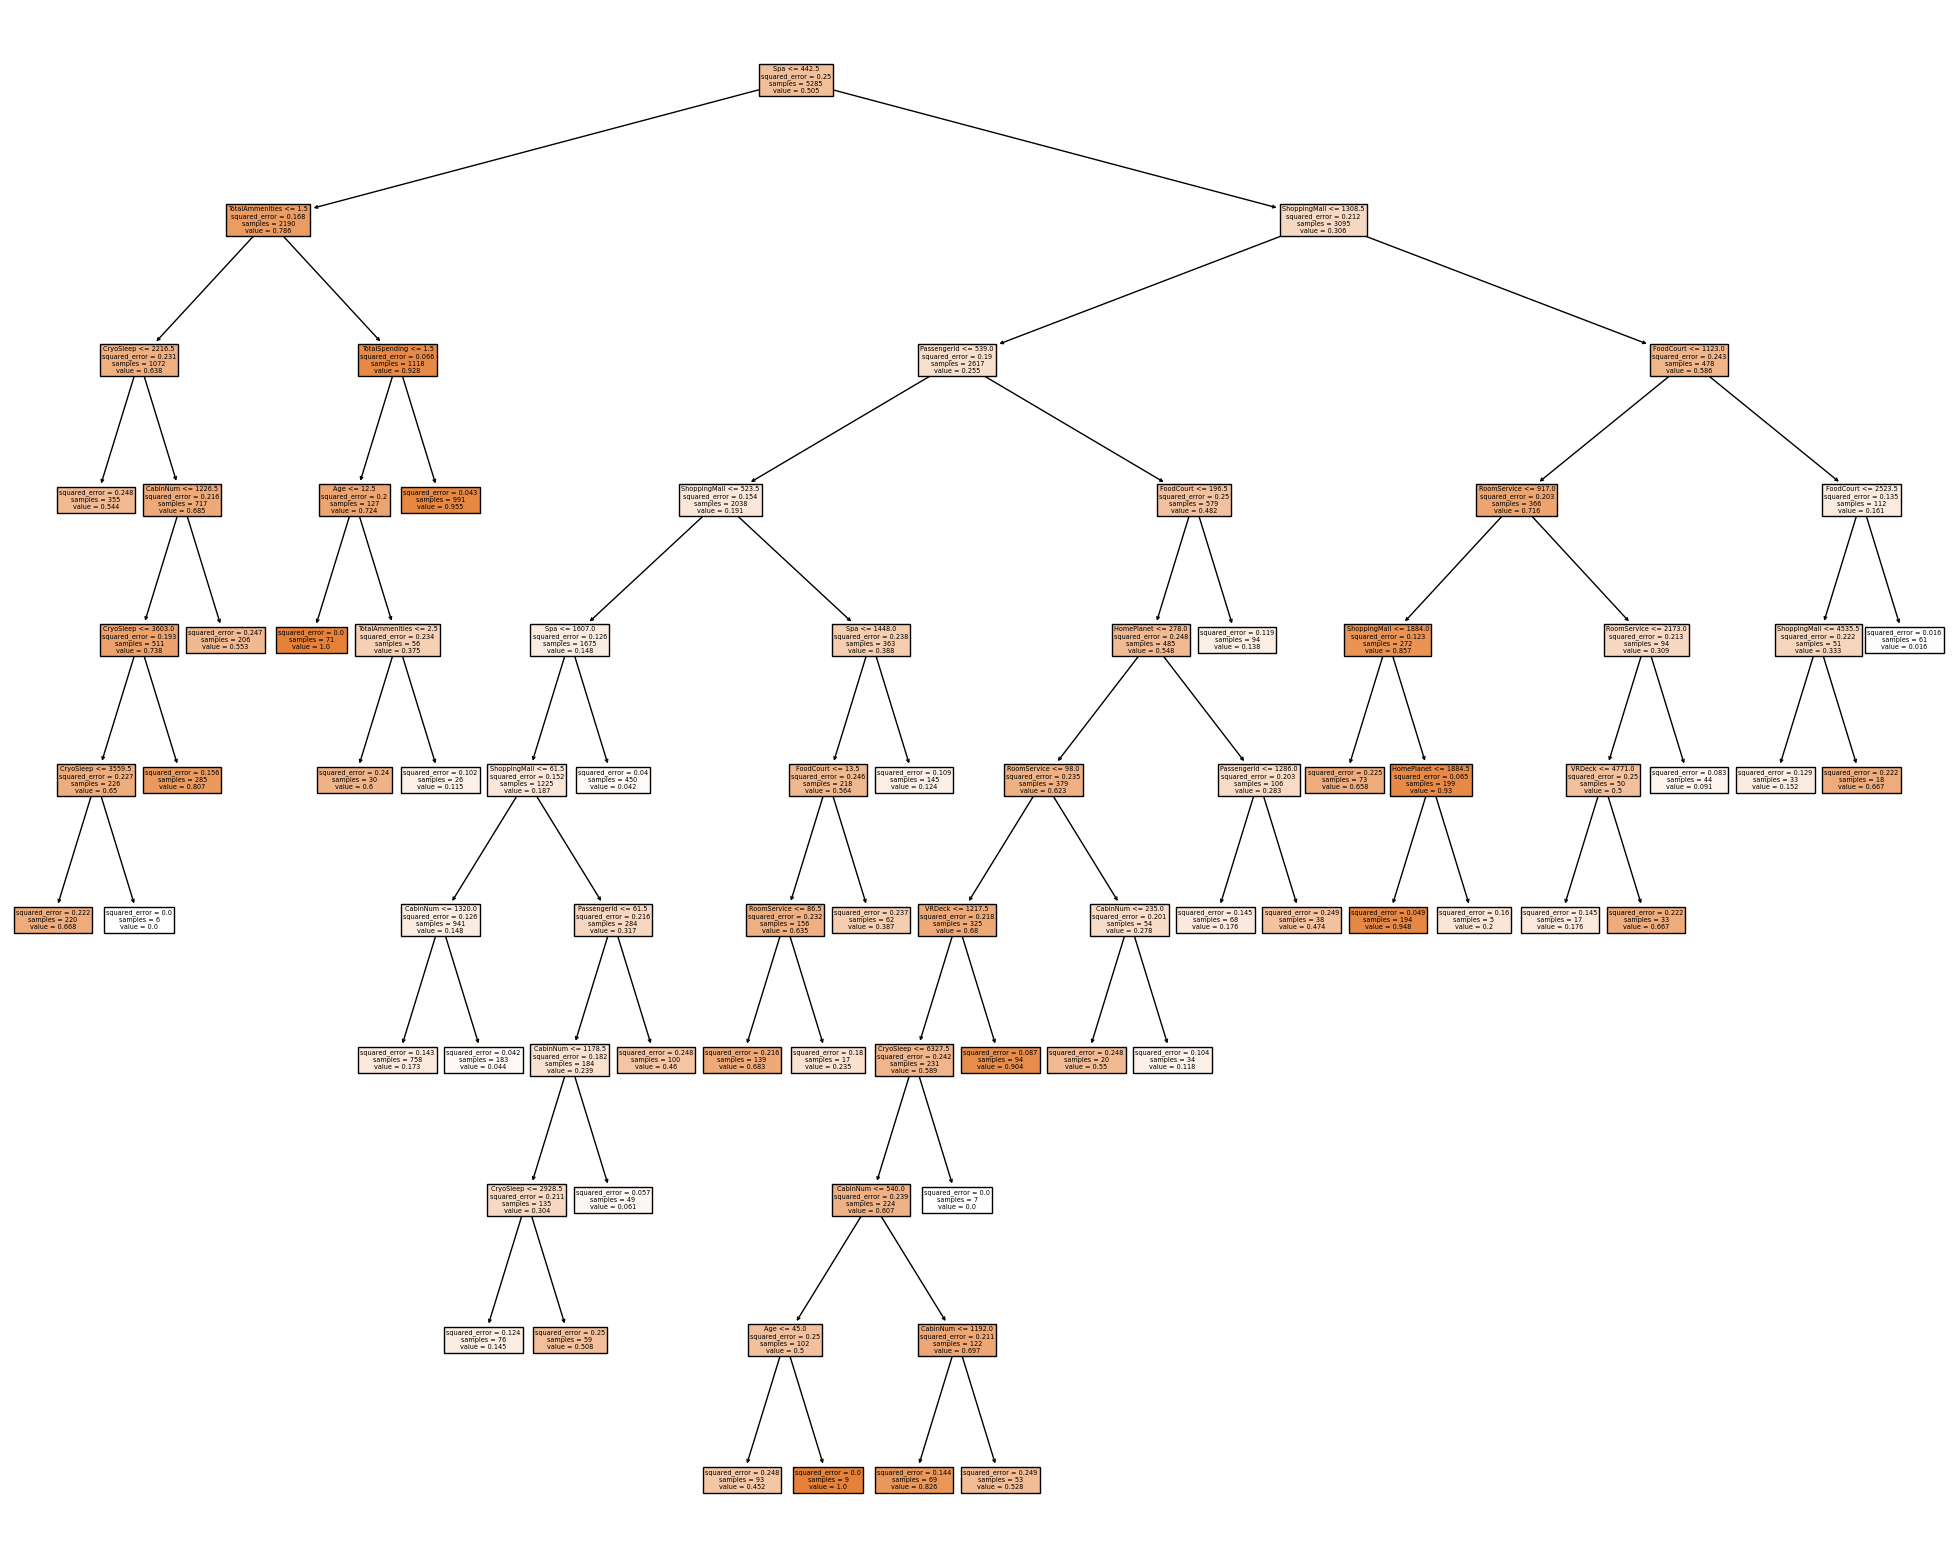

In [836]:
splits = RandomSplitter(seed = 1)(range_of(trainsubset))
dep_var = 'Transported'
procs = [Categorify,FillMissing]
cont,cat = cont_cat_split(trainsubset,1, dep_var=dep_var)
to = TabularPandas(trainsubset, procs, cat, cont, y_names=dep_var,splits = splits)

xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=40)
m.fit(xs, y)

fig = plt.figure(figsize=(25,20))
a = list(trainsubset.columns)
_ = tree.plot_tree(m,
                   feature_names= a,
                   filled=True)

print('decision tree prediction',((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y))


1 is false 1 is earth 2 is eruopa 3 is mars

In [825]:
def do():
    mae = []
    predk = []
    oob = []
    for i in range(5):
        m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 100,oob_score=True)
        m.fit(xs, y)
        preds = m.predict(valid_xs)
        predk.append((preds == valid_y).sum() / len(valid_y))
        mae.append(mean_absolute_error(valid_y, preds))
        oob.append(m.oob_score_)
    print("mae",np.mean(mae))
    print("preds",np.mean(predk))
    print("oob",np.mean(oob))
do()

mae 0.21014383043149132
preds 0.7898561695685087
oob 0.7950804162724692


In [798]:
testdf

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,GroupNumber,FirstName,LastName,CabinDeck,CabinSide,CabinNum,Under18,Under19,Under13,GroupSize,CabinSize,SoloCabin,FamilySize,TotalAmmenities,TotalCabinAmmenities,TotalSpending,TotalCabinSpending,TotalCabinRoomService,VRDeck_Family,Spa_Family,RoomService_Family,FoodCourt_Family,ShoppingMall_Family,TotalFamilyAmmenities,TotalFamilySpending,Transported
2445,5335_01,Europa,True,A/49/P,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,0.0,Aldah Moring,5335.0,1.0,Aldah,Moring,A,P,49,False,False,False,4,4,False,3,0.0,7738.0,0.0,12532.0,4794.0,330.0,24.0,13.0,3209.0,0.0,3563.0,3576.0,False
1503,3244_01,Europa,True,A/38/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Shaiaz Sessory,3244.0,1.0,Shaiaz,Sessory,A,S,38,False,False,False,3,3,False,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
392,0827_03,Europa,True,A/7/P,55 Cancri e,67.0,False,0.0,0.0,0.0,0.0,0.0,Phah Speery,827.0,3.0,Phah,Speery,A,P,7,False,False,False,3,3,False,3,0.0,4381.0,0.0,4381.0,0.0,30.0,1678.0,0.0,2673.0,0.0,4381.0,4381.0,False
391,0827_02,Europa,False,A/7/P,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,0.0,Luxonon Speery,827.0,2.0,Luxonon,Speery,A,P,7,False,False,False,3,3,False,3,0.0,4381.0,0.0,4381.0,0.0,30.0,1678.0,0.0,2673.0,0.0,4381.0,4381.0,False
69,0157_01,Europa,False,A/1/P,TRAPPIST-1e,35.0,False,0.0,463.0,0.0,1502.0,585.0,Dabit Fulazy,157.0,1.0,Dabit,Fulazy,A,P,1,False,False,False,1,1,True,1,2550.0,2550.0,2550.0,2550.0,0.0,585.0,1502.0,0.0,463.0,0.0,2550.0,2550.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,3208_01,Europa,False,T/4/P,TRAPPIST-1e,27.0,False,0.0,11293.0,0.0,297.0,4736.0,Thabius Reeddommy,3208.0,1.0,Thabius,Reeddommy,T,P,4,False,False,False,1,1,True,1,16326.0,16326.0,16326.0,16326.0,0.0,4736.0,297.0,0.0,11293.0,0.0,16326.0,16326.0,False
1051,2217_01,Europa,False,T/1/S,TRAPPIST-1e,26.0,False,132.0,2576.0,0.0,2060.0,3.0,Alarmus Brantcable,2217.0,1.0,Alarmus,Brantcable,T,S,1,False,False,False,1,1,True,1,4639.0,4639.0,4771.0,4771.0,132.0,3.0,2060.0,132.0,2576.0,0.0,4639.0,4771.0,False
3212,7046_02,Europa,False,T/3/S,55 Cancri e,44.0,False,0.0,1190.0,0.0,1906.0,167.0,Genubih Ativeezy,7046.0,2.0,Genubih,Ativeezy,T,S,3,False,False,False,2,2,False,2,3263.0,6110.0,3263.0,6110.0,0.0,2167.0,2414.0,0.0,1529.0,0.0,6110.0,6110.0,False
3213,7046_03,Europa,False,T/3/S,TRAPPIST-1e,47.0,False,0.0,339.0,0.0,508.0,2000.0,Zinon Ativeezy,7046.0,3.0,Zinon,Ativeezy,T,S,3,False,False,False,2,2,False,2,2847.0,6110.0,2847.0,6110.0,0.0,2167.0,2414.0,0.0,1529.0,0.0,6110.0,6110.0,False


In [831]:
testdf.Transported

2445    False
1503    False
392     False
391     False
69      False
        ...  
1494    False
1051    False
3212    False
3213    False
244     False
Name: Transported, Length: 3281, dtype: bool

In [827]:
testdf[testdf.CryoSleep == True]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,GroupNumber,FirstName,LastName,CabinDeck,CabinSide,CabinNum,Under18,Under19,Under13,GroupSize,CabinSize,SoloCabin,FamilySize,TotalAmmenities,TotalCabinAmmenities,TotalSpending,TotalCabinSpending,TotalCabinRoomService,VRDeck_Family,Spa_Family,RoomService_Family,FoodCourt_Family,ShoppingMall_Family,TotalFamilyAmmenities,TotalFamilySpending
2445,5335_01,Europa,True,A/49/P,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,0.0,Aldah Moring,5335.0,1.0,Aldah,Moring,A,P,49,False,False,False,4,4,False,3,0.0,7738.0,0.0,12532.0,4794.0,330.0,24.0,13.0,3209.0,0.0,3563.0,3576.0
1503,3244_01,Europa,True,A/38/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Shaiaz Sessory,3244.0,1.0,Shaiaz,Sessory,A,S,38,False,False,False,3,3,False,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,0827_03,Europa,True,A/7/P,55 Cancri e,67.0,False,0.0,0.0,0.0,0.0,0.0,Phah Speery,827.0,3.0,Phah,Speery,A,P,7,False,False,False,3,3,False,3,0.0,4381.0,0.0,4381.0,0.0,30.0,1678.0,0.0,2673.0,0.0,4381.0,4381.0
1504,3244_02,Europa,True,A/38/S,TRAPPIST-1e,46.0,False,0.0,0.0,0.0,0.0,0.0,Shain Sessory,3244.0,2.0,Shain,Sessory,A,S,38,False,False,False,3,3,False,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1064,2245_02,Europa,True,A/17/P,TRAPPIST-1e,45.0,True,0.0,0.0,0.0,0.0,0.0,Izares Hyling,2245.0,2.0,Izares,Hyling,A,P,17,False,False,False,1,1,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,4907_01,Earth,True,G/801/S,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,Eliana Estron,4907.0,1.0,Eliana,Estron,G,S,801,True,True,False,1,1,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2255,4894_01,Earth,True,G/798/S,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,Laude Guerson,4894.0,1.0,Laude,Guerson,G,S,798,True,True,False,1,1,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2247,4859_01,Earth,True,G/793/S,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,Claura Brenney,4859.0,1.0,Claura,Brenney,G,S,793,False,False,False,1,1,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2244,4855_01,Earth,True,G/781/P,PSO J318.5-22,23.0,False,0.0,0.0,0.0,0.0,0.0,Rayley Cartyernan,4855.0,1.0,Rayley,Cartyernan,G,P,781,False,False,False,1,1,True,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [837]:
to_new = to.train.new(testdf)
to_new.process()

testtran = [True if x >0.5 else False for x in list(m.predict(to_new.xs))]
testdf['Transported'] = testtran

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [748]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:25]

,cols,imp
3,TotalSpending,0.496766
7,FoodCourt,0.111398
1,HomePlanet,0.076896
5,Spa,0.074871
10,ShoppingMall,0.067679
6,VRDeck,0.055142
11,CabinNum,0.026023
12,Age,0.022869
2,PassengerId,0.020119
9,RoomService,0.019120


In [741]:
list(fi[16:25].cols)

[]

In [657]:
subset = list(fi.cols[:28])
subset.append('Transported')
drop = list(fi.cols[28:])

In [839]:
testdf.Transported.value_counts()

Transported
True     1783
False    1498
Name: count, dtype: int64

In [716]:
testdf[(testdf.HomePlanet == 'Earth') & (testdf.Age > 35) & (testdf.CryoSleep == True)].Transported.value_counts()

Transported
False    112
Name: count, dtype: int64

In [838]:
testdf[testdf.CryoSleep == True].Transported.value_counts()

Transported
True    1216
Name: count, dtype: int64

In [720]:
rem = ['Cabin','FirstName','Name','VRDeck_Family',
 'Spa_Family',
 'TotalCabinAmmenities',
 'TotalFamilySpending',
 'RoomService_Family',
 'TotalCabinSpending',
 'TotalCabinRoomService',
 'ShoppingMall_Family',
 'TotalFamilyAmmenities','LastName','CabinDeck','Group','FoodCourt_Family']


In [710]:
subset

['TotalSpending',
 'TotalAmmenities',
 'CryoSleep',
 'Spa',
 'VRDeck',
 'FoodCourt',
 'FoodCourt_Family',
 'RoomService',
 'ShoppingMall',
 'HomePlanet',
 'CabinDeck',
 'PassengerId',
 'CabinNum',
 'Age',
 'Group',
 'LastName',
 'Transported']

In [749]:
for item in ['FoodCourt_Family']:
    subset.remove(item)

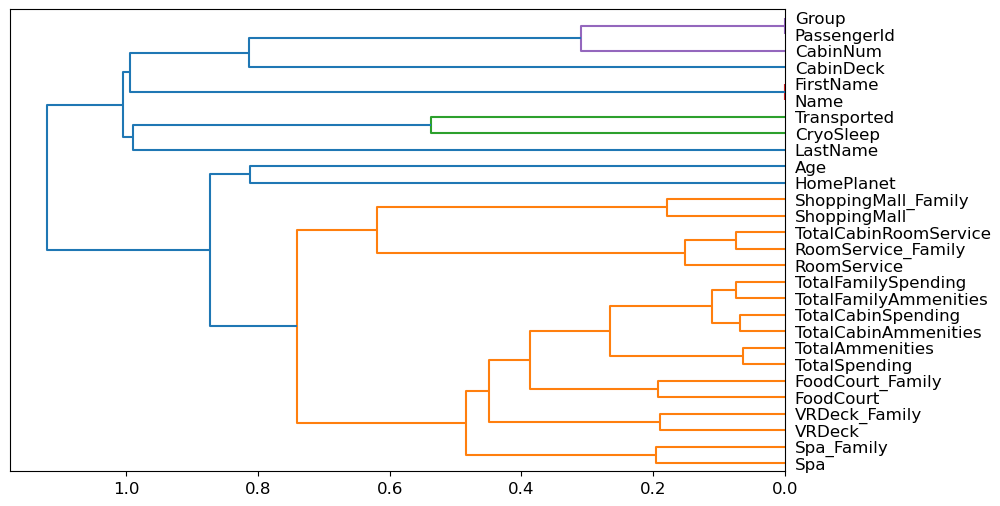

In [689]:
cluster_columns(trainsubset)


In [840]:
droptest['Transported'] = False


In [841]:
restdf = testdf.copy()

In [842]:
res2 = restdf[['PassengerId','Transported']]


In [843]:
result2 = pd.concat([droptest,res2])
result2 = result2.sort_index()


In [844]:
result2

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,0018_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,0019_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,0021_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,0023_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,False
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,False
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,False


In [845]:
result2 = result2[['PassengerId','Transported']]

In [847]:
result2

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [855]:
traindf[traindf.CabinDeck == 'E'].HomePlanet.value_counts()

HomePlanet
Earth     313
Mars      268
Europa    102
Name: count, dtype: int64

In [846]:
result2.Transported.value_counts()

Transported
False    2494
True     1783
Name: count, dtype: int64

In [849]:
result2.to_csv("submit.csv",index = False)

In [892]:
traindf[['CabinNum','CabinDeck','PassengerId','CabinSide']].sort_index()[:50]

,CabinNum,CabinDeck,PassengerId,CabinSide
0,0,B,0001_01,P
1,0,F,0002_01,S
2,0,A,0003_01,S
3,0,A,0003_02,S
4,1,F,0004_01,S
5,0,F,0005_01,P
6,2,F,0006_01,S
8,3,F,0007_01,S
9,1,B,0008_01,P
11,1,B,0008_03,P


In [886]:
for i in range(0,300):
    if len(traindf[traindf.Group == traindf.loc[cc[i]].Group].CabinDeck) > 2:
        print(traindf[traindf.Group == traindf.loc[cc[i]].Group].CabinDeck)

7520    A
7522    A
7523    A
Name: CabinDeck, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'T']
5674    A
5675    A
5676    A
5678    A
Name: CabinDeck, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'T']
8102    A
8101    A
8103    A
Name: CabinDeck, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'T']
8180    A
8179    A
8178    A
Name: CabinDeck, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'T']
4185    A
4184    A
4183    A
Name: CabinDeck, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'T']
1568    A
1567    A
1566    A
Name: CabinDeck, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'T']
6363    A
6362    A
6361    A
Name: CabinDeck, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'T']
6342    A
6341    A
6340    A
6338    A
Name:

In [860]:
cc = list(traindf[(traindf.TotalSpending == 0) & (traindf.HomePlanet == 'Europa')][['Group','CabinDeck']].index)

In [872]:
len(cc)

789